# Experiment 03 - Data

Create data splits

In [1]:
import logging
from functools import partial
from pathlib import Path
from typing import List, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from IPython.display import display
from sklearn.model_selection import train_test_split

import pimmslearn
import pimmslearn.io.load
from pimmslearn.analyzers import analyzers
from pimmslearn.io.datasplits import DataSplits
from pimmslearn.sampling import feature_frequency
from pimmslearn.sklearn import get_PCA

logger = pimmslearn.logging.setup_nb_logger()
logger.info("Split data and make diagnostic plots")
logging.getLogger('fontTools').setLevel(logging.WARNING)


def align_meta_data(df: pd.DataFrame, df_meta: pd.DataFrame):
    try:
        df = df.loc[df_meta.index]
    except KeyError as e:
        logger.warning(e)
        logger.warning("Ignore missing samples in quantified samples")
        df = df.loc[df.index.intersection(
            df_meta.index)]
    return df_meta


pd.options.display.max_columns = 32
plt.rcParams['figure.figsize'] = [4, 2]

pimmslearn.plotting.make_large_descriptors(7)

figures = {}  # collection of ax or figures
dumps = {}  # collection of data dumps

root - INFO     Split data and make diagnostic plots


## Arguments

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

In [3]:
FN_INTENSITIES: str = 'data/dev_datasets/HeLa_6070/protein_groups_wide_N50.csv'  # Sample (rows), features (columns)
index_col: Union[str, int] = 0  # Can be either a string or position (default 0 for first column), or a list of these.
column_names: List[str] = ["Gene Names"]  # Manuelly set column names (of Index object in columns)
fn_rawfile_metadata: str = 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv'  # metadata for samples (rows)
feat_prevalence: Union[int, float] = 0.25  # Minimum number or fraction of feature prevalence across samples to be kept
sample_completeness: Union[int, float] = 0.5  # Minimum number or fraction of total requested features per Sample
select_N: int = None  # only use latest N samples
sample_N: bool = False  # if select_N, sample N randomly instead of using latest N
random_state: int = 42  # random state for reproducibility of splits
logarithm: str = 'log2'  # Log transformation of initial data (select one of the existing in numpy)
folder_experiment: str = 'runs/example'  # folder to save figures and data dumps
folder_data: str = ''  # specify special data directory if needed
file_format: str = 'csv'  # file format of create splits, default pickle (pkl)
use_every_nth_xtick: int = 1  # use every nth xtick in plots (default 1, i.e. every xtick is kept)
# metadata -> defaults for metadata extracted from machine data, used for plotting
meta_date_col: str = None  # date column in meta data
meta_cat_col: str = None  # category column in meta data
# train, validation and test data splits
frac_non_train: float = 0.1  # fraction of non training data (validation and test split)
frac_mnar: float = 0.0  # fraction of missing not at random data, rest: missing completely at random
prop_sample_w_sim: float = 1.0  # proportion of samples with simulated missing values
feat_name_display: str = None  # display name for feature name (e.g. 'protein group')

In [4]:
# Parameters
FN_INTENSITIES = "https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/proteome.csv"
sample_completeness = 0.5
feat_prevalence = 0.25
column_names = ["protein groups"]
index_col = 0
meta_cat_col = "_collection site"
meta_date_col = None
frac_mnar = 0.25
frac_non_train = 0.1
fn_rawfile_metadata = "https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv"
folder_experiment = "runs/alzheimer_study"


In [5]:
args = pimmslearn.nb.get_params(args, globals=globals())
args

root - INFO     Removed from global namespace: FN_INTENSITIES


root - INFO     Removed from global namespace: index_col


root - INFO     Removed from global namespace: column_names


root - INFO     Removed from global namespace: fn_rawfile_metadata


root - INFO     Removed from global namespace: feat_prevalence


root - INFO     Removed from global namespace: sample_completeness


root - INFO     Removed from global namespace: select_N


root - INFO     Removed from global namespace: sample_N


root - INFO     Removed from global namespace: random_state


root - INFO     Removed from global namespace: logarithm


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: use_every_nth_xtick


root - INFO     Removed from global namespace: meta_date_col


root - INFO     Removed from global namespace: meta_cat_col


root - INFO     Removed from global namespace: frac_non_train


root - INFO     Removed from global namespace: frac_mnar


root - INFO     Removed from global namespace: prop_sample_w_sim


root - INFO     Removed from global namespace: feat_name_display


{'FN_INTENSITIES': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/proteome.csv',
 'index_col': 0,
 'column_names': ['protein groups'],
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv',
 'feat_prevalence': 0.25,
 'sample_completeness': 0.5,
 'select_N': None,
 'sample_N': False,
 'random_state': 42,
 'logarithm': 'log2',
 'folder_experiment': 'runs/alzheimer_study',
 'folder_data': '',
 'file_format': 'csv',
 'use_every_nth_xtick': 1,
 'meta_date_col': None,
 'meta_cat_col': '_collection site',
 'frac_non_train': 0.1,
 'frac_mnar': 0.25,
 'prop_sample_w_sim': 1.0,
 'feat_name_display': None}

In [6]:
args = pimmslearn.nb.args_from_dict(args)
args

{'FN_INTENSITIES': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/proteome.csv',
 'column_names': ['protein groups'],
 'data': PosixPath('runs/alzheimer_study/data'),
 'feat_name_display': None,
 'feat_prevalence': 0.25,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'frac_mnar': 0.25,
 'frac_non_train': 0.1,
 'index_col': 0,
 'logarithm': 'log2',
 'meta_cat_col': '_collection site',
 'meta_date_col': None,
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'prop_sample_w_sim': 1.0,
 'random_state': 42,
 'sample_N': False,
 'sample_completeness': 0.5,
 'select_N'

In [7]:
if not 0.0 <= args.frac_mnar <= 1.0:
    raise ValueError("Invalid MNAR float value (should be betw. 0 and 1):"
                     f" {args.frac_mnar}")

if isinstance(args.index_col, str) or isinstance(args.index_col, int):
    args.overwrite_entry('index_col', [args.index_col])
args.index_col  # make sure it is an iterable

[0]

## Raw data

process arguments

In [8]:
logger.info(f"{args.FN_INTENSITIES = }")


FILE_FORMAT_TO_CONSTRUCTOR = {'csv': 'from_csv',
                              'pkl': 'from_pickle',
                              'pickle': 'from_pickle',
                              }

FILE_EXT = Path(args.FN_INTENSITIES).suffix[1:]
logger.info(
    f"File format (extension): {FILE_EXT}  (!specifies data loading function!)")

root - INFO     args.FN_INTENSITIES = 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/proteome.csv'


root - INFO     File format (extension): csv  (!specifies data loading function!)


In [9]:
# ! factor out file reading to a separate module, not class
# AnalyzePeptides.from_csv
constructor = getattr(pimmslearn.io.load, FILE_FORMAT_TO_CONSTRUCTOR[FILE_EXT])
df = constructor(fname=args.FN_INTENSITIES,
                 index_col=args.index_col,
                 )
if args.column_names:
    df.columns.names = args.column_names
if args.feat_name_display is None:
    args.overwrite_entry('feat_name_display', 'features')
    if args.column_names:
        args.overwrite_entry('feat_name_display', args.column_names[0])


if not df.index.name:
    logger.warning("No sample index name found, setting to 'Sample ID'")
    df.index.name = 'Sample ID'

if args.logarithm:
    log_fct = getattr(np, args.logarithm)
    df = log_fct(df)  # ! potentially add check to increase value by 1 if 0 is present (should be part of preprocessing)
df

pimmslearn.io.load - WARNING  Passed unknown kwargs: {}


protein groups  A0A024QZX5;A0A087X1N8;P35237  A0A024R0T9;K7ER74;P02655  \
Sample ID                                                                
Sample_000                            15.912                    16.852   
Sample_001                            15.936                    16.874   
Sample_002                            16.111                    14.523   
Sample_003                            16.107                    17.032   
Sample_004                            15.603                    15.331   
...                                      ...                       ...   
Sample_205                            15.682                    16.886   
Sample_206                            15.798                    17.554   
Sample_207                            15.739                    16.877   
Sample_208                            15.477                    16.779   
Sample_209                            15.727                    17.261   

protein groups  A0A024R3B9;E9PJL7;E9PNH7;E9PR44;E9PRA8;P02511  \
Sample ID                                                       
Sample_000                                                NaN   
Sample_001                                                NaN   
Sample_002                                                NaN   
Sample_003                                                NaN   
Sample_004                                                NaN   
...                                                       ...   
Sample_205                                             14.061   
Sample_206                                             15.266   
Sample_207                                                NaN   
Sample_208                                                NaN   
Sample_209                                             15.344   

protein groups  A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8  \
Sample ID                                                                                        
Sample_000                                                 15.570                                
Sample_001                                                 15.519                                
Sample_002                                                 15.935                                
Sample_003                                                 15.802                                
Sample_004                                                 15.375                                
...                                                           ...                                
Sample_205                                                 14.910                                
Sample_206                                                 15.600                                
Sample_207                                                 15.469                                
Sample_208                                                 14.995                                
Sample_209                                                 15.175                                

protein groups  A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503  A0A075B6H7  \
Sample ID                                                             
Sample_000                                       16.481      17.301   
Sample_001                                       16.387      13.796   
Sample_002                                       16.416      18.175   
Sample_003                                       16.979      15.963   
Sample_004                                       16.679      15.473   
...                                                 ...         ...   
Sample_205                                       16.482         NaN   
Sample_206                                       15.938         NaN   
Sample_207                                       16.898         NaN   
Sample_208                                       16.132         NaN   
Sample_209                                       16.235         

Text(0, 0.5, 'Frequency')

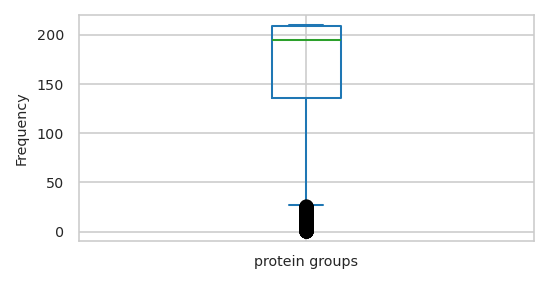

In [10]:
ax = (df
      .notna()
      .sum(axis=0)
      .to_frame(df.columns.name)
      .plot
      .box()
      )
ax.set_ylabel('Frequency')

In [11]:
fname = args.out_folder / '01_0_data_stats.xlsx'
dumps[fname.name] = fname.as_posix()
writer = pd.ExcelWriter(fname)

notna = df.notna()
data_stats_original = pd.concat(
    [
        notna.sum().describe().rename('feat_stats'),
        notna.sum(axis=1).describe().rename('sample_stats')
    ],
    axis=1)
data_stats_original.to_excel(writer, sheet_name='data_stats_original')
data_stats_original

feat_stats  sample_stats
count   1,542.000       210.000
mean      165.477     1,215.071
std        57.677       105.904
min         1.000       801.000
25%       136.000     1,155.000
50%       195.000     1,236.000
75%       209.000     1,297.750
max       210.000     1,377.000

In case there are multiple features for each intensity values (currenlty: peptide sequence and charge),
combine the column names to a single str index.

> The Collaborative Modeling approach will need a single feature column.

In [12]:
def join_as_str(seq):
    ret = "_".join(str(x) for x in seq)
    return ret


if isinstance(df.columns, pd.MultiIndex):
    logger.warning("combine MultiIndex columns to one feature column")
    print(df.columns[:10].map(join_as_str))
    _new_name = join_as_str(df.columns.names)
    df.columns = df.columns.map(join_as_str)
    df.columns.name = _new_name
    logger.warning(f"New name: {df.columns.names = }")

## Machine metadata

- read from file using [ThermoRawFileParser](https://github.com/compomics/ThermoRawFileParser)

In [13]:
if args.fn_rawfile_metadata:
    df_meta = pd.read_csv(args.fn_rawfile_metadata, index_col=0)
else:
    logger.warning("No metadata for samples provided, create placeholder.")
    if args.meta_date_col:
        raise ValueError(
            f"No metadata provided, but data column set: {args.meta_date_col}")
    if args.meta_cat_col:
        raise ValueError(
            f"No metadata provided, but data column set: {args.meta_cat_col}")
    df_meta = pd.DataFrame(index=df.index)
df_meta = df_meta.loc[df.index.to_list()]  # index is sample index
if df_meta.index.name is None:
    df_meta.index.name = args.index_col[0]
df_meta

_collection site  _age at CSF collection _gender  _t-tau [ng/L]  \
Sample ID                                                                    
Sample_000           Sweden                  71.000       f        703.000   
Sample_001           Sweden                  77.000       m        518.000   
Sample_002           Sweden                  75.000       m        974.000   
Sample_003           Sweden                  72.000       f        950.000   
Sample_004           Sweden                  63.000       f        873.000   
...                     ...                     ...     ...            ...   
Sample_205           Berlin                  69.000       f      1,945.000   
Sample_206           Berlin                  73.000       m        299.000   
Sample_207           Berlin                  71.000       f        262.000   
Sample_208           Berlin                  83.000       m        289.000   
Sample_209           Berlin                  63.000       f        591.000   

            _p-tau [ng/L]  _Abeta-42 [ng/L]  _Abeta-40 [ng/L]  \
Sample ID                                                       
Sample_000         85.000           562.000               NaN   
Sample_001         91.000           334.000               NaN   
Sample_002         87.000           515.000               NaN   
Sample_003        109.000           394.000               NaN   
Sample_004         88.000           234.000               NaN   
...                   ...               ...               ...   
Sample_205            NaN           699.000        12,140.000   
Sample_206            NaN         1,420.000        16,571.000   
Sample_207            NaN           639.000         9,663.000   
Sample_208            NaN         1,436.000        11,285.000   
Sample_209            NaN         1,299.000        11,232.000   

            _Abeta-42/Abeta-40 ratio _primary biochemical AD classification  \
Sample ID                                                                     
Sample_000                       NaN                    biochemical control   
Sample_001                       NaN                         biochemical AD   
Sample_002                       NaN                         biochemical AD   
Sample_003                       NaN                         biochemical AD   
Sample_004                       NaN                         biochemical AD   
...                              ...                                    ...   
Sample_205                     0.058                         biochemical AD   
Sample_206                     0.086                    biochemical control   
Sample_207                     0.066                    biochemical control   
Sample_208                     0.127                    biochemical control   
Sample_209                     0.116                    biochemical control   

           _clinical AD diagnosis  _MMSE score  
Sample ID                                       
Sample_000                    NaN          NaN  
Sample_001                    NaN          NaN  
Sample_002                    NaN          NaN  
Sample_003                    NaN          NaN  
Sample_004                    NaN          NaN  
...                           ...          ...  
Sample_205                     AD       17.000  
Sample_206                 non-AD       28.000  
Sample_207                 non-AD       28.000  
Sample_208                 non-AD       24.000  
Sample_209                 non-AD       29.000  

[210 rows x 11 columns]

In [14]:
if args.meta_date_col:
    df_meta[args.meta_date_col] = pd.to_datetime(
        df_meta[args.meta_date_col])
else:
    args.overwrite_entry('meta_date_col', 'PlaceholderTime')
    df_meta[args.meta_date_col] = range(len(df_meta))
df_meta

_collection site  _age at CSF collection _gender  _t-tau [ng/L]  \
Sample ID                                                                    
Sample_000           Sweden                  71.000       f        703.000   
Sample_001           Sweden                  77.000       m        518.000   
Sample_002           Sweden                  75.000       m        974.000   
Sample_003           Sweden                  72.000       f        950.000   
Sample_004           Sweden                  63.000       f        873.000   
...                     ...                     ...     ...            ...   
Sample_205           Berlin                  69.000       f      1,945.000   
Sample_206           Berlin                  73.000       m        299.000   
Sample_207           Berlin                  71.000       f        262.000   
Sample_208           Berlin                  83.000       m        289.000   
Sample_209           Berlin                  63.000       f        591.000   

            _p-tau [ng/L]  _Abeta-42 [ng/L]  _Abeta-40 [ng/L]  \
Sample ID                                                       
Sample_000         85.000           562.000               NaN   
Sample_001         91.000           334.000               NaN   
Sample_002         87.000           515.000               NaN   
Sample_003        109.000           394.000               NaN   
Sample_004         88.000           234.000               NaN   
...                   ...               ...               ...   
Sample_205            NaN           699.000        12,140.000   
Sample_206            NaN         1,420.000        16,571.000   
Sample_207            NaN           639.000         9,663.000   
Sample_208            NaN         1,436.000        11,285.000   
Sample_209            NaN         1,299.000        11,232.000   

            _Abeta-42/Abeta-40 ratio _primary biochemical AD classification  \
Sample ID                                                                     
Sample_000                       NaN                    biochemical control   
Sample_001                       NaN                         biochemical AD   
Sample_002                       NaN                         biochemical AD   
Sample_003                       NaN                         biochemical AD   
Sample_004                       NaN                         biochemical AD   
...                              ...                                    ...   
Sample_205                     0.058                         biochemical AD   
Sample_206                     0.086                    biochemical control   
Sample_207                     0.066                    biochemical control   
Sample_208                     0.127                    biochemical control   
Sample_209                     0.116                    biochemical control   

           _clinical AD diagnosis  _MMSE score  PlaceholderTime  
Sample ID                                                        
Sample_000                    NaN          NaN                0  
Sample_001                    NaN          NaN                1  
Sample_002                    NaN          NaN                2  
Sample_003                    NaN          NaN                3  
Sample_004                    NaN          NaN                4  
...                           ...          ...              ...  
Sample_205                     AD       17.000              205  
Sample_206                 non-AD       28.000              206  
Sample_207                 non-AD       28.000              207  
Sample_208                 non-AD       24.000              208  
Sample_209                 non-AD       29.000              209  

[210 rows x 12 columns]

In [15]:
df_meta.describe(percentiles=np.linspace(0.05, 0.95, 10))

_age at CSF collection  _t-tau [ng/L]  _p-tau [ng/L]  _Abeta-42 [ng/L]  \
count                 197.000        181.000         98.000           181.000   
mean                   67.726        553.624         72.449           687.105   
std                    12.123        372.272         40.869           381.119   
min                    20.000         78.000         16.000           154.000   
5%                     42.800        149.000         24.000           249.000   
15%                    60.000        218.000         33.000           349.000   
25%                    63.000        275.000         36.750           417.000   
35%                    67.000        320.000         45.900           478.000   
45%                    69.000        383.000         60.300           544.000   
50%                    70.000        441.000         73.500           593.000   
55%                    71.000        519.000         77.000           629.000   
65%                    72.000        654.000         87.000           740.000   
75%                    74.000        802.000         93.750           892.000   
85%                    77.000        920.000        109.000         1,016.000   
95%                    83.000      1,183.000        144.150         1,436.000   
max                    88.000      2,390.000        233.000         2,206.000   

       _Abeta-40 [ng/L]  _Abeta-42/Abeta-40 ratio  _MMSE score  \
count           121.000                   121.000       83.000   
mean         10,505.843                     0.079       25.723   
std           5,192.847                     0.047        4.028   
min           2,450.000                     0.016       12.000   
5%            3,959.000                     0.031       17.100   
15%           5,748.000                     0.037       21.000   
25%           6,608.000                     0.045       23.500   
35%           7,866.000                     0.052       25.700   
45%           9,016.000                     0.063       27.000   
50%           9,515.000                     0.067       27.000   
55%          10,171.000                     0.078       28.000   
65%          11,466.000                     0.091       28.000   
75%          12,967.000                     0.105       29.000   
85%          16,531.000                     0.119       29.000   
95%          20,554.000                     0.144       30.000   
max          26,080.000                     0.370       30.000   

       PlaceholderTime  
count          210.000  
mean           104.500  
std             60.766  
min              0.000  
5%              10.450  
15%             31.350  
25%             52.250  
35%             73.150  
45%             94.050  
50%            104.500  
55%            114.950  
65%            135.850  
75%            156.750  
85%            177.650  
95%            198.550  
max            209.000

In [16]:
df_meta = df_meta.sort_values(args.meta_date_col)

In [17]:
meta_stats = df_meta.describe(include='all')
meta_stats

_collection site  _age at CSF collection _gender  _t-tau [ng/L]  \
count               197                 197.000     197        181.000   
unique                4                     NaN       2            NaN   
top              Berlin                     NaN       f            NaN   
freq                 83                     NaN      99            NaN   
mean                NaN                  67.726     NaN        553.624   
std                 NaN                  12.123     NaN        372.272   
min                 NaN                  20.000     NaN         78.000   
25%                 NaN                  63.000     NaN        275.000   
50%                 NaN                  70.000     NaN        441.000   
75%                 NaN                  74.000     NaN        802.000   
max                 NaN                  88.000     NaN      2,390.000   

        _p-tau [ng/L]  _Abeta-42 [ng/L]  _Abeta-40 [ng/L]  \
count          98.000           181.000           121.000   
unique            NaN               NaN               NaN   
top               NaN               NaN               NaN   
freq              NaN               NaN               NaN   
mean           72.449           687.105        10,505.843   
std            40.869           381.119         5,192.847   
min            16.000           154.000         2,450.000   
25%            36.750           417.000         6,608.000   
50%            73.500           593.000         9,515.000   
75%            93.750           892.000        12,967.000   
max           233.000         2,206.000        26,080.000   

        _Abeta-42/Abeta-40 ratio _primary biochemical AD classification  \
count                    121.000                                    197   
unique                       NaN                                      2   
top                          NaN                    biochemical control   
freq                         NaN                                    109   
mean                       0.079                                    NaN   
std                        0.047                                    NaN   
min                        0.016                                    NaN   
25%                        0.045                                    NaN   
50%                        0.067                                    NaN   
75%                        0.105                                    NaN   
max                        0.370                                    NaN   

       _clinical AD diagnosis  _MMSE score  PlaceholderTime  
count                     137       83.000          210.000  
unique                      2          NaN              NaN  
top                    non-AD          NaN              NaN  
freq                       88          NaN              NaN  
mean                      NaN       25.723          104.500  
std                       NaN        4.028           60.766  
min                       NaN       12.000            0.000  
25%                       NaN       23.500           52.250  
50%                       NaN       27.000          104.500  
75%                       NaN       29.000          156.750  
max                       NaN       30.000          209.000

subset with variation

In [18]:
try:
    display(meta_stats.loc[:, (meta_stats.loc['unique']
            > 1) | (meta_stats.loc['std'] > 0.1)])
except KeyError:
    if 'std' in meta_stats.index:
        display(meta_stats.loc[:, (meta_stats.loc['std'] > 0.1)])
    if 'unique' in meta_stats.index:
        display(meta_stats.loc[:, (meta_stats.loc['std'] > 0.1)])

_collection site  _age at CSF collection _gender  _t-tau [ng/L]  \
count               197                 197.000     197        181.000   
unique                4                     NaN       2            NaN   
top              Berlin                     NaN       f            NaN   
freq                 83                     NaN      99            NaN   
mean                NaN                  67.726     NaN        553.624   
std                 NaN                  12.123     NaN        372.272   
min                 NaN                  20.000     NaN         78.000   
25%                 NaN                  63.000     NaN        275.000   
50%                 NaN                  70.000     NaN        441.000   
75%                 NaN                  74.000     NaN        802.000   
max                 NaN                  88.000     NaN      2,390.000   

        _p-tau [ng/L]  _Abeta-42 [ng/L]  _Abeta-40 [ng/L]  \
count          98.000           181.000           121.000   
unique            NaN               NaN               NaN   
top               NaN               NaN               NaN   
freq              NaN               NaN               NaN   
mean           72.449           687.105        10,505.843   
std            40.869           381.119         5,192.847   
min            16.000           154.000         2,450.000   
25%            36.750           417.000         6,608.000   
50%            73.500           593.000         9,515.000   
75%            93.750           892.000        12,967.000   
max           233.000         2,206.000        26,080.000   

       _primary biochemical AD classification _clinical AD diagnosis  \
count                                     197                    137   
unique                                      2                      2   
top                       biochemical control                 non-AD   
freq                                      109                     88   
mean                                      NaN                    NaN   
std                                       NaN                    NaN   
min                                       NaN                    NaN   
25%                                       NaN                    NaN   
50%                                       NaN                    NaN   
75%                                       NaN                    NaN   
max                                       NaN                    NaN   

        _MMSE score  PlaceholderTime  
count        83.000          210.000  
unique          NaN              NaN  
top             NaN              NaN  
freq            NaN              NaN  
mean         25.723          104.500  
std           4.028           60.766  
min          12.000            0.000  
25%          23.500           52.250  
50%          27.000          104.500  
75%          29.000          156.750  
max          30.000          209.000

In [19]:
df_meta = align_meta_data(df, df_meta=df_meta)

Ensure unique indices

In [20]:
assert df.index.is_unique, "Duplicates in index."

## Select a subset of samples if specified (reduce the number of samples)

- select features if `select_N` is specifed (for now)
- for interpolation to make sense, it is best to select a consecutive number of samples:
  - take N most recent samples (-> check that this makes sense for your case)

In [21]:
if args.select_N is not None:
    args.select_N = min(args.select_N, len(df_meta))
    if args.sample_N:
        df_meta = df_meta.sample(args.select_N)
    else:
        df_meta = df_meta.iloc[-args.select_N:]

    df = df.loc[df_meta.index].dropna(
        how='all', axis=1)
    ax = df.T.describe().loc['count'].hist()
    _ = ax.set_title('histogram of features for all eligable samples')

## First Step: Select features by prevalence
- `feat_prevalence` across samples

In [22]:
! add function
freq_per_feature = df.notna().sum()  # on wide format
if isinstance(args.feat_prevalence, float):
    N_samples = len(df)
    logger.info(f"Current number of samples: {N_samples}")
    logger.info(
        f"Feature has to be present in at least {args.feat_prevalence:.2%} of samples")
    args.overwrite_entry('feat_prevalence', int(
        N_samples * args.feat_prevalence))
assert isinstance(args.feat_prevalence, int)
! check that feature prevalence is greater equal to 3 (otherwise train, val, test split is not possible)
logger.info(
    f"Feature has to be present in at least {args.feat_prevalence} of samples")
# select features
mask = freq_per_feature >= args.feat_prevalence
logger.info(f"Drop {(~mask).sum()} features")
freq_per_feature = freq_per_feature.loc[mask]
df = df.loc[:, mask]
df

/bin/bash: line 1: add: command not found


root - INFO     Current number of samples: 210


root - INFO     Feature has to be present in at least 25.00% of samples


/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: ` check that feature prevalence is greater equal to 3 (otherwise train, val, test split is not possible)'


root - INFO     Feature has to be present in at least 52 of samples


root - INFO     Drop 121 features


protein groups  A0A024QZX5;A0A087X1N8;P35237  A0A024R0T9;K7ER74;P02655  \
Sample ID                                                                
Sample_000                            15.912                    16.852   
Sample_001                            15.936                    16.874   
Sample_002                            16.111                    14.523   
Sample_003                            16.107                    17.032   
Sample_004                            15.603                    15.331   
...                                      ...                       ...   
Sample_205                            15.682                    16.886   
Sample_206                            15.798                    17.554   
Sample_207                            15.739                    16.877   
Sample_208                            15.477                    16.779   
Sample_209                            15.727                    17.261   

protein groups  A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8  \
Sample ID                                                                                        
Sample_000                                                 15.570                                
Sample_001                                                 15.519                                
Sample_002                                                 15.935                                
Sample_003                                                 15.802                                
Sample_004                                                 15.375                                
...                                                           ...                                
Sample_205                                                 14.910                                
Sample_206                                                 15.600                                
Sample_207                                                 15.469                                
Sample_208                                                 14.995                                
Sample_209                                                 15.175                                

protein groups  A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503  A0A075B6H7  \
Sample ID                                                             
Sample_000                                       16.481      17.301   
Sample_001                                       16.387      13.796   
Sample_002                                       16.416      18.175   
Sample_003                                       16.979      15.963   
Sample_004                                       16.679      15.473   
...                                                 ...         ...   
Sample_205                                       16.482         NaN   
Sample_206                                       15.938         NaN   
Sample_207                                       16.898         NaN   
Sample_208                                       16.132         NaN   
Sample_209                                       16.235         NaN   

protein groups  A0A075B6H9  A0A075B6I0  A0A075B6I1  A0A075B6I6  A0A075B6I9  \
Sample ID                                                                    
Sample_000          20.246      16.764      17.584      16.988      20.054   
Sample_001          19.941      18.786      17.144         NaN      19.067   
Sample_002          19.251      16.832      15.671      17.012      18.569   
Sample_003          19.628      17.852      18.877      14.182      18.985   
Sample_004          20.450      18.682      17.081      14.140      19.686   
...                    ...         ...         ...         ...         ...   
Sample_205          17.705      17.039         NaN      16.413      19.102   
Sample_206          18.154      18.152      16.503      16.860      18.538   
Sample_207          18.636      17.950      16.321      16

In [23]:
notna = df.notna()
data_stats_filtered = pd.concat(
    [
        notna.sum().describe().rename('feat_stats'),
        notna.sum(axis=1).describe().rename('sample_stats')
    ],
    axis=1)
data_stats_filtered.to_excel(writer, sheet_name='data_stats_filtered')
data_stats_filtered

feat_stats  sample_stats
count   1,421.000       210.000
mean      177.346     1,200.043
std        42.341       100.703
min        52.000       800.000
25%       155.000     1,147.000
50%       200.000     1,220.000
75%       210.000     1,278.750
max       210.000     1,342.000

## Second step - Sample selection

Select samples based on completeness

In [24]:
if isinstance(args.sample_completeness, float):
    msg = f'Fraction of minimum sample completeness over all features specified with: {args.sample_completeness}\n'
    # assumes df in wide format
    args.overwrite_entry('sample_completeness', int(
        df.shape[1] * args.sample_completeness))
    msg += f'This translates to a minimum number of features per sample (to be included): {args.sample_completeness}'
    logger.info(msg)

sample_counts = df.notna().sum(axis=1)  # if DataFrame
sample_counts.describe()

root - INFO     Fraction of minimum sample completeness over all features specified with: 0.5
This translates to a minimum number of features per sample (to be included): 710


count     210.000
mean    1,200.043
std       100.703
min       800.000
25%     1,147.000
50%     1,220.000
75%     1,278.750
max     1,342.000
dtype: float64

In [25]:
mask = sample_counts > args.sample_completeness
msg = f'Drop {len(mask) - mask.sum()} of {len(mask)} initial samples.'
logger.info(msg)
df = df.loc[mask]
df = df.dropna(
    axis=1, how='all')  # drop now missing features

root - INFO     Drop 0 of 210 initial samples.


In [26]:
args.N, args.M = df.shape  # save data dimensions
args.used_samples = df.index.to_list()

### Histogram of features per sample

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/0_1_hist_features_per_sample


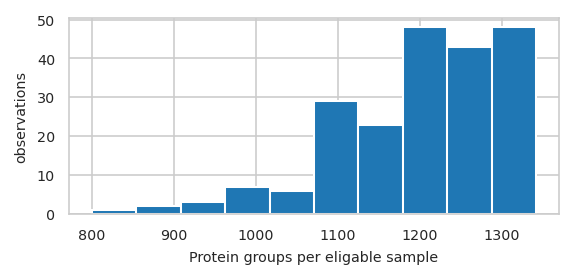

In [27]:
group = 1
ax = df.notna().sum(axis=1).hist()
ax.set_xlabel(f'{args.feat_name_display.capitalize()} per eligable sample')
ax.set_ylabel('observations')
fname = args.out_figures / f'0_{group}_hist_features_per_sample'
figures[fname.stem] = fname
pimmslearn.savefig(ax.get_figure(), fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/0_1_feature_prevalence


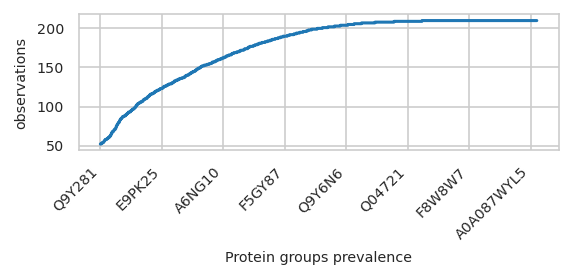

In [28]:
ax = df.notna().sum(axis=0).sort_values().plot()
_new_labels = [l_.get_text().split(';')[0] for l_ in ax.get_xticklabels()]
_ = ax.set_xticklabels(_new_labels, rotation=45,
                       horizontalalignment='right')
ax.set_xlabel(f'{args.feat_name_display.capitalize()} prevalence')
ax.set_ylabel('observations')
fname = args.out_figures / f'0_{group}_feature_prevalence'
figures[fname.stem] = fname
pimmslearn.savefig(ax.get_figure(), fname)

### Number off observations accross feature value

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/0_1_intensity_distribution_overall


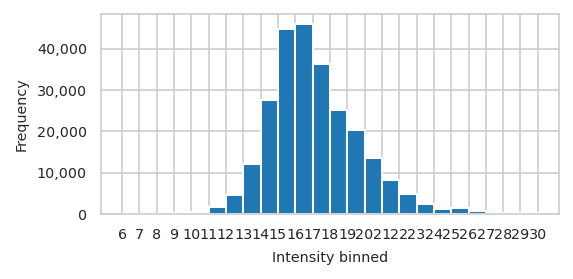

In [29]:
min_max = pimmslearn.plotting.data.min_max(df.stack())
ax, bins = pimmslearn.plotting.data.plot_histogram_intensities(
    df.stack(), min_max=min_max)
ax.set_xlabel('Intensity binned')
fname = args.out_figures / f'0_{group}_intensity_distribution_overall'

figures[fname.stem] = fname
pimmslearn.savefig(ax.get_figure(), fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/0_1_intensity_median_vs_prop_missing_scatter


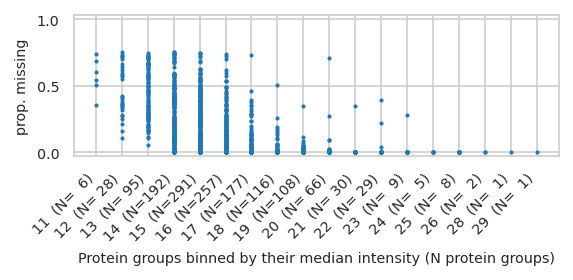

In [30]:
ax = pimmslearn.plotting.data.plot_feat_median_over_prop_missing(
    data=df, type='scatter')
fname = args.out_figures / f'0_{group}_intensity_median_vs_prop_missing_scatter'
ax.set_xlabel(
    f'{args.feat_name_display.capitalize()} binned by their median intensity'
    f' (N {args.feat_name_display})')
figures[fname.stem] = fname
pimmslearn.savefig(ax.get_figure(), fname)

/home/runner/work/pimms/pimms/project/.snakemake/conda/924ec7e362d761ecf0807b9074d79999_/lib/python3.12/site-packages/pimmslearn/plotting/data.py:327: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax = ax[0]  # returned series due to by argument?


pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/0_1_intensity_median_vs_prop_missing_boxplot


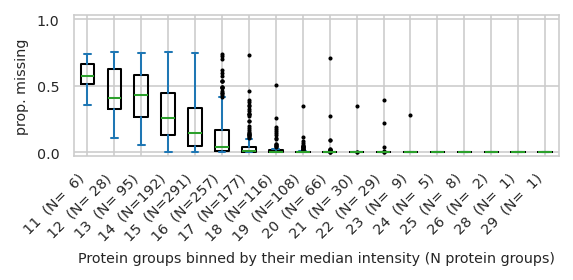

In [31]:
ax, _data_feat_median_over_prop_missing = pimmslearn.plotting.data.plot_feat_median_over_prop_missing(
    data=df, type='boxplot', return_plot_data=True)
fname = args.out_figures / f'0_{group}_intensity_median_vs_prop_missing_boxplot'
ax.set_xlabel(
    f'{args.feat_name_display.capitalize()} binned by their median intensity'
    f' (N {args.feat_name_display})')
figures[fname.stem] = fname
pimmslearn.savefig(ax.get_figure(), fname)
_data_feat_median_over_prop_missing.to_csv(fname.with_suffix('.csv'))
# _data_feat_median_over_prop_missing.to_excel(fname.with_suffix('.xlsx'))
del _data_feat_median_over_prop_missing

### Interactive and Single plots

In [32]:
_feature_display_name = f'identified {args.feat_name_display}'
sample_counts.name = _feature_display_name

In [33]:
K = 2
df = df.astype(float)
pcs = get_PCA(df, n_components=K)  # should be renamed to get_PCs
pcs = pcs.iloc[:, :K].join(df_meta).join(sample_counts)

pcs_name = pcs.columns[:2]
pcs_index_name = pcs.index.name
pcs = pcs.reset_index()
pcs

Sample ID  principal component 1 (11.62 %)  \
0    Sample_000                          -16.681   
1    Sample_001                          -12.801   
2    Sample_002                          -13.784   
3    Sample_003                          -16.440   
4    Sample_004                          -15.129   
..          ...                              ...   
205  Sample_205                            6.682   
206  Sample_206                            7.405   
207  Sample_207                            7.329   
208  Sample_208                            8.058   
209  Sample_209                            3.657   

     principal component 2 (10.17 %) _collection site  _age at CSF collection  \
0                             -8.492           Sweden                  71.000   
1                             -5.119           Sweden                  77.000   
2                            -12.951           Sweden                  75.000   
3                            -10.112           Sweden                  72.000   
4                             -6.471           Sweden                  63.000   
..                               ...              ...                     ...   
205                          -15.297           Berlin                  69.000   
206                           -6.126           Berlin                  73.000   
207                          -11.041           Berlin                  71.000   
208                           -5.501           Berlin                  83.000   
209                           -7.572           Berlin                  63.000   

    _gender  _t-tau [ng/L]  _p-tau [ng/L]  _Abeta-42 [ng/L]  _Abeta-40 [ng/L]  \
0         f        703.000         85.000           562.000               NaN   
1         m        518.000         91.000           334.000               NaN   
2         m        974.000         87.000           515.000               NaN   
3         f        950.000        109.000           394.000               NaN   
4         f        873.000         88.000           234.000               NaN   
..      ...            ...            ...               ...               ...   
205       f      1,945.000            NaN           699.000        12,140.000   
206       m        299.000            NaN         1,420.000        16,571.000   
207       f        262.000            NaN           639.000         9,663.000   
208       m        289.000            NaN         1,436.000        11,285.000   
209       f        591.000            NaN         1,299.000        11,232.000   

     _Abeta-42/Abeta-40 ratio _primary biochemical AD classification  \
0                         NaN                    biochemical control   
1                         NaN                         biochemical AD   
2                         NaN                         biochemical AD   
3                         NaN                         biochemical AD   
4                         NaN                         biochemical AD   
..                        ...                                    ...   
205                     0.058                         biochemical AD   
206                     0.086                    biochemical control   
207                     0.066                    biochemical control   
208                     0.127                    biochemical control   
209                     0.116                    biochemical control   

    _clinical AD diagnosis  _MMSE score  PlaceholderTime  \
0                      NaN          NaN                0   
1                      NaN          NaN                1   
2                      NaN          NaN                2   
3                      NaN          NaN                3   
4                      NaN          NaN                4   
..                     ...          ...              ...   
205                     AD       17.000              205   
206                 non-AD       28.000              206   
207                 non-AD    

In [34]:
pcs.describe(include='all').T

count unique                  top  \
Sample ID                                  210    210           Sample_000   
principal component 1 (11.62 %)        210.000    NaN                  NaN   
principal component 2 (10.17 %)        210.000    NaN                  NaN   
_collection site                           197      4               Berlin   
_age at CSF collection                 197.000    NaN                  NaN   
_gender                                    197      2                    f   
_t-tau [ng/L]                          181.000    NaN                  NaN   
_p-tau [ng/L]                           98.000    NaN                  NaN   
_Abeta-42 [ng/L]                       181.000    NaN                  NaN   
_Abeta-40 [ng/L]                       121.000    NaN                  NaN   
_Abeta-42/Abeta-40 ratio               121.000    NaN                  NaN   
_primary biochemical AD classification     197      2  biochemical control   
_clinical AD diagnosis                     137      2               non-AD   
_MMSE score                             83.000    NaN                  NaN   
PlaceholderTime                        210.000    NaN                  NaN   
identified protein groups              210.000    NaN                  NaN   

                                       freq       mean       std       min  \
Sample ID                                 1        NaN       NaN       NaN   
principal component 1 (11.62 %)         NaN     -0.000     8.981   -17.550   
principal component 2 (10.17 %)         NaN     -0.000     8.404   -18.953   
_collection site                         83        NaN       NaN       NaN   
_age at CSF collection                  NaN     67.726    12.123    20.000   
_gender                                  99        NaN       NaN       NaN   
_t-tau [ng/L]                           NaN    553.624   372.272    78.000   
_p-tau [ng/L]                           NaN     72.449    40.869    16.000   
_Abeta-42 [ng/L]                        NaN    687.105   381.119   154.000   
_Abeta-40 [ng/L]                        NaN 10,505.843 5,192.847 2,450.000   
_Abeta-42/Abeta-40 ratio                NaN      0.079     0.047     0.016   
_primary biochemical AD classification  109        NaN       NaN       NaN   
_clinical AD diagnosis                   88        NaN       NaN       NaN   
_MMSE score                             NaN     25.723     4.028    12.000   
PlaceholderTime                         NaN    104.500    60.766     0.000   
identified protein groups               NaN  1,200.043   100.703   800.000   

                                             25%       50%        75%  \
Sample ID                                    NaN       NaN        NaN   
principal component 1 (11.62 %)          -11.061     4.635      6.655   
principal component 2 (10.17 %)           -6.310     0.305      5.485   
_collection site                             NaN       NaN        NaN   
_age at CSF collection                    63.000    70.000     74.000   
_gender                                      NaN       NaN        NaN   
_t-tau [ng/L]                            275.000   441.000    802.000   
_p-tau [ng/L]                             36.750    73.500     93.750   
_Abeta-42 [ng/L]                         417.000   593.000    892.000   
_Abeta-40 [ng/L]                       6,608.000 9,515.000 12,967.000   
_Abeta-42/Abeta-40 ratio                   0.045     0.067      0.105   
_primary biochemical AD classification       NaN       NaN        NaN   
_clinical AD diagnosis                       NaN       NaN        NaN   
_MMSE score                               23.500    27.000     29.000   
PlaceholderTime                           52.250   104.500    156.750   
identified protein groups              1,147.000 1,220.000  1,278.750   

                                              max  
Sample ID                                     NaN  
principal component 1 (11.62 %)          

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/0_1_pca_sample_by__collection_site


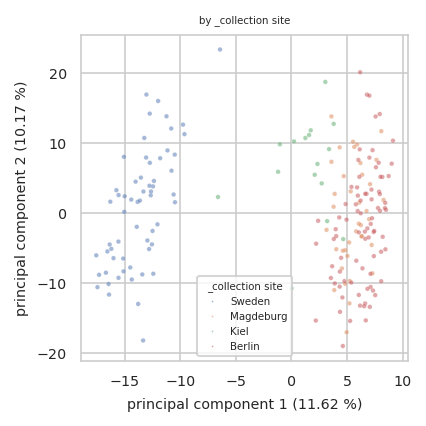

In [35]:
if args.meta_cat_col:
    fig, ax = plt.subplots(figsize=(3, 3))
    analyzers.seaborn_scatter(
        pcs[pcs_name], ax, meta=pcs[args.meta_cat_col], title=f"by {args.meta_cat_col}")
    fname = (args.out_figures
             / f'0_{group}_pca_sample_by_{"_".join(args.meta_cat_col.split())}')
    figures[fname.stem] = fname
    pimmslearn.savefig(fig, fname)

In [36]:
if args.meta_date_col != 'PlaceholderTime':
    fig, ax = plt.subplots()
    analyzers.plot_date_map(
        df=pcs[pcs_name], ax=ax, dates=pcs[args.meta_date_col], title=f'by {args.meta_date_col}')
    fname = args.out_figures / f'0_{group}_pca_sample_by_date'
    figures[fname.stem] = fname
    pimmslearn.savefig(fig, fname)

- size: number of features in a single sample

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/0_1_pca_sample_by_identified_protein_groups.pdf


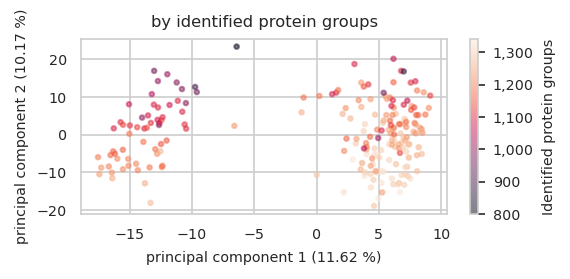

In [37]:
fig, ax = plt.subplots()
col_identified_feat = _feature_display_name
analyzers.plot_scatter(
    pcs[pcs_name],
    ax,
    pcs[col_identified_feat],
    feat_name_display=args.feat_name_display,
    size=5,
)
fname = (args.out_figures
         / f'0_{group}_pca_sample_by_{"_".join(col_identified_feat.split())}.pdf')
figures[fname.stem] = fname
pimmslearn.savefig(fig, fname)

In [38]:
# ! write principal components to excel (if needed)
# pcs.set_index([df.index.name])[[*pcs_name, col_identified_feat]].to_excel(fname.with_suffix('.xlsx'))

In [39]:
fig = px.scatter(
    pcs, x=pcs_name[0], y=pcs_name[1],
    hover_name=pcs_index_name,
    # hover_data=analysis.df_meta,
    title=f'First two Principal Components of {args.M} {args.feat_name_display} for {pcs.shape[0]} samples',
    # color=pcs['Software Version'],
    color=col_identified_feat,
    template='none',
    width=1200,  # 4 inches x 300 dpi
    height=600  # 2 inches x 300 dpi
)
fname = (args.out_figures
         / f'0_{group}_pca_sample_by_{"_".join(col_identified_feat.split())}_plotly.pdf')
figures[fname.stem] = fname
fig.write_image(fname)
fig  # stays interactive in html

choreographer.browsers.chromium - INFO     Chromium init'ed with kwargs {}


choreographer.browsers.chromium - INFO     Found chromium path: /usr/bin/google-chrome


choreographer.utils._tmpfile - INFO     Temp directory created: /tmp/tmp8en2t9dh.


choreographer.browser_async - INFO     Opening browser.


choreographer.utils._tmpfile - INFO     Temp directory created: /tmp/tmpesnmtc3y.


choreographer.browsers.chromium - INFO     ldd failed. e: Command '['ldd', '/usr/bin/google-chrome']' returned non-zero exit status 1., stderr: None


choreographer.browsers.chromium - INFO     Temporary directory at: /tmp/tmpesnmtc3y


kaleido.kaleido - INFO     Conforming 1 to file:///tmp/tmp8en2t9dh/index.html


kaleido.kaleido - INFO     Waiting on all navigates


kaleido.kaleido - INFO     All navigates done, putting them all in queue.


kaleido.kaleido - INFO     Getting tab from queue (has 1)


kaleido.kaleido - INFO     Got CCF1


kaleido._kaleido_tab - INFO     Processing First_two_Principal_Components_of_1421_protein_groups_for_210_samples.pdf


kaleido._kaleido_tab - INFO     Sending big command for First_two_Principal_Components_of_1421_protein_groups_for_210_samples.pdf.


kaleido._kaleido_tab - INFO     Sent big command for First_two_Principal_Components_of_1421_protein_groups_for_210_samples.pdf.


kaleido.kaleido - INFO     Reloading tab CCF1 before return.


kaleido.kaleido - INFO     Putting tab CCF1 back (queue size: 0).


kaleido.kaleido - INFO     Waiting for all cleanups to finish.


kaleido.kaleido - INFO     Exiting Kaleido


choreographer.utils._tmpfile - INFO     TemporaryDirectory.cleanup() worked.


choreographer.utils._tmpfile - INFO     shutil.rmtree worked.


kaleido.kaleido - INFO     Cancelling tasks.


kaleido.kaleido - INFO     Exiting Kaleido/Choreo


choreographer.browser_async - INFO     Closing browser.


choreographer.utils._tmpfile - INFO     TemporaryDirectory.cleanup() worked.


choreographer.utils._tmpfile - INFO     shutil.rmtree worked.


kaleido.kaleido - INFO     Cancelling tasks.


kaleido.kaleido - INFO     Exiting Kaleido/Choreo


choreographer.browser_async - INFO     Closing browser.


choreographer.utils._tmpfile - INFO     TemporaryDirectory.cleanup() worked.


choreographer.utils._tmpfile - INFO     shutil.rmtree worked.


choreographer.utils._tmpfile - INFO     TemporaryDirectory.cleanup() worked.


choreographer.utils._tmpfile - INFO     shutil.rmtree worked.


## Sample Medians and percentiles

In [40]:
df.head()

protein groups  A0A024QZX5;A0A087X1N8;P35237  A0A024R0T9;K7ER74;P02655  \
Sample ID                                                                
Sample_000                            15.912                    16.852   
Sample_001                            15.936                    16.874   
Sample_002                            16.111                    14.523   
Sample_003                            16.107                    17.032   
Sample_004                            15.603                    15.331   

protein groups  A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8  \
Sample ID                                                                                        
Sample_000                                                 15.570                                
Sample_001                                                 15.519                                
Sample_002                                                 15.935                                
Sample_003                                                 15.802                                
Sample_004                                                 15.375                                

protein groups  A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503  A0A075B6H7  \
Sample ID                                                             
Sample_000                                       16.481      17.301   
Sample_001                                       16.387      13.796   
Sample_002                                       16.416      18.175   
Sample_003                                       16.979      15.963   
Sample_004                                       16.679      15.473   

protein groups  A0A075B6H9  A0A075B6I0  A0A075B6I1  A0A075B6I6  A0A075B6I9  \
Sample ID                                                                    
Sample_000          20.246      16.764      17.584      16.988      20.054   
Sample_001          19.941      18.786      17.144         NaN      19.067   
Sample_002          19.251      16.832      15.671      17.012      18.569   
Sample_003          19.628      17.852      18.877      14.182      18.985   
Sample_004          20.450      18.682      17.081      14.140      19.686   

protein groups  A0A075B6J9  A0A075B6K4  A0A075B6K5  A0A075B6P5;P01615  \
Sample ID                                                               
Sample_000             NaN      16.148      17.343             17.016   
Sample_001          16.188      16.127      17.417             17.779   
Sample_002             NaN      15.387      17.236             17.431   
Sample_003          13.438      16.565      16.267             16.990   
Sample_004          14.495      16.418      17.390             17.493   

protein groups  A0A075B6Q5  A0A075B6R2  ...  Q9Y4L1  Q9Y5F6;Q9Y5F6-2  \
Sample ID                               ...                            
Sample_000             NaN         NaN  ...  18.598           16.469   
Sample_001             NaN         NaN  ...  18.476           15.782   
Sample_002          15.128      16.280  ...  18.991           17.015   
Sample_003             NaN      16.777  ...  18.560           16.529   
Sample_004             NaN      17.497  ...  18.305           16.285   

protein groups  Q9Y5I4;Q9Y5I4-2  Q9Y5Y7  Q9Y617  Q9Y646  \
Sample ID                                                 
Sample_000               17.187  18.840  16.859  19.322   
Sample_001               17.447  19.195  16.799  19.190   
Sample_002               17.410  19.088  16.288  19.702   
Sample_003               17.545  18.715  17.075  19.760   
Sample_004               17.297  18.668  16.736  19.624   

protein groups  Q9Y653;Q9Y653-2;Q9Y653-3  Q9Y696  Q9Y6C2  Q9Y6N6  \
Sample ID                                                          
Sample_000                        16.012  15.178     NaN  15.050   
Sample_001                        15.528  15.576     NaN  14.833   
Sample_002                        15.229  14.7

In [41]:
df_w_date = df.join(df_meta[args.meta_date_col])
df_w_date = df_w_date.set_index(args.meta_date_col).sort_index()
if not args.meta_date_col == 'PlaceholderTime':
    df_w_date.to_period('min')
df_w_date = df_w_date.T
df_w_date

PlaceholderTime                                       0      1      2    \
A0A024QZX5;A0A087X1N8;P35237                       15.912 15.936 16.111   
A0A024R0T9;K7ER74;P02655                           16.852 16.874 14.523   
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;... 15.570 15.519 15.935   
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503            16.481 16.387 16.416   
A0A075B6H7                                         17.301 13.796 18.175   
...                                                   ...    ...    ...   
Q9Y6R7                                             19.863 20.299 19.598   
Q9Y6X5                                                NaN 15.556 15.735   
Q9Y6Y8;Q9Y6Y8-2                                    19.563 19.386 20.447   
Q9Y6Y9                                             12.837 13.970 12.636   
S4R3U6                                             12.805 12.442 12.505   

PlaceholderTime                                       3      4      5    \
A0A024QZX5;A0A087X1N8;P35237                       16.107 15.603 15.812   
A0A024R0T9;K7ER74;P02655                           17.032 15.331 18.614   
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;... 15.802 15.375 15.624   
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503            16.979 16.679 15.958   
A0A075B6H7                                         15.963 15.473 18.317   
...                                                   ...    ...    ...   
Q9Y6R7                                             19.429 19.582 19.130   
Q9Y6X5                                                NaN 15.328    NaN   
Q9Y6Y8;Q9Y6Y8-2                                    20.216 19.867 19.633   
Q9Y6Y9                                             12.627 13.145 12.224   
S4R3U6                                             12.445 12.235    NaN   

PlaceholderTime                                       6      7      8    \
A0A024QZX5;A0A087X1N8;P35237                       15.500 15.221 15.980   
A0A024R0T9;K7ER74;P02655                           17.409 17.684 16.386   
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;... 15.912 15.385 15.894   
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503            16.234 16.418 16.271   
A0A075B6H7                                            NaN 17.214 17.794   
...                                                   ...    ...    ...   
Q9Y6R7                                             18.690 18.996 19.993   
Q9Y6X5                                                NaN    NaN    NaN   
Q9Y6Y8;Q9Y6Y8-2                                    20.057 18.680 20.023   
Q9Y6Y9                                             12.817 12.897    NaN   
S4R3U6                                                NaN    NaN 13.008   

PlaceholderTime                                       9      10     11   \
A0A024QZX5;A0A087X1N8;P35237                       15.679 15.981 15.983   
A0A024R0T9;K7ER74;P02655                           16.590 15.948 16.669   
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;... 15.375 15.993 15.654   
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503            16.210 16.742 16.159   
A0A075B6H7                                            NaN 16.166 16.681   
...                                                   ...    ...    ...   
Q9Y6R7                                             18.550 19.727 19.216   
Q9Y6X5                                                NaN 15.187 15.403   
Q9Y6Y8;Q9Y6Y8-2                                    19.948 19.047 20.855   
Q9Y6Y9                                             13.685 13.478 12.923   
S4R3U6                                             12.279 12.534 11.679   

PlaceholderTime                                       12     13     14   \
A0A024QZX5;A0A087X1N8;P35237                       15.949 15.475 15.706   
A0A024R0T9;K7ER74;P02655                           17.694 17.726 17.252   
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;... 15.751 15.191 15.469   
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503            15.790 16.403 16.433   
A0A075B6H7           

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/0_1_median_boxplot


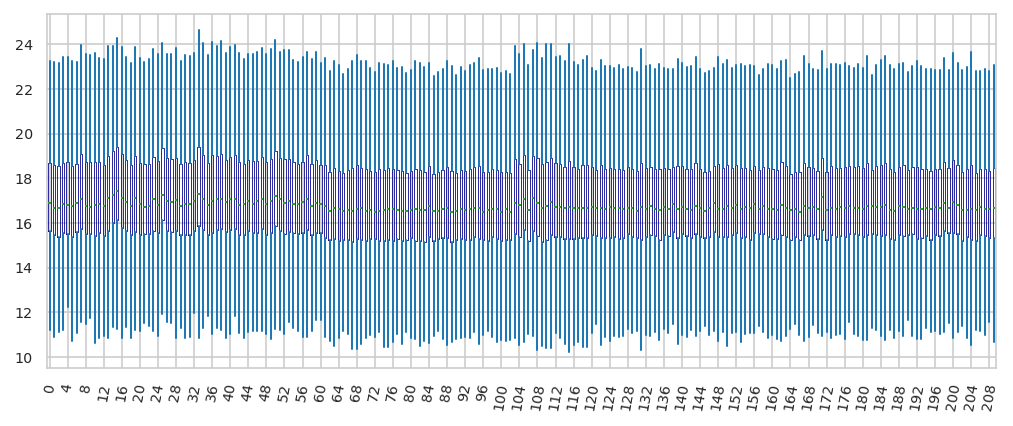

In [42]:
ax = df_w_date.plot.box(rot=80,
                        figsize=(7, 3),
                        fontsize=7,
                        showfliers=False,
                        showcaps=False,
                        boxprops=dict(linewidth=.4, color='darkblue'),
                        flierprops=dict(markersize=.4, color='lightblue'),
                        )
_ = pimmslearn.plotting.select_xticks(ax)
fig = ax.get_figure()
fname = args.out_figures / f'0_{group}_median_boxplot'
df_w_date.to_pickle(fname.with_suffix('.pkl'))
figures[fname.stem] = fname
pimmslearn.savefig(fig, fname)
del df_w_date

Percentiles of intensities in dataset

In [43]:
df.stack().describe(percentiles=np.linspace(0.05, 0.95, 19).round(2))

count   252,009.000
mean         17.119
std           2.567
min           6.695
5%           13.564
10%          14.280
15%          14.739
20%          15.098
25%          15.404
30%          15.677
35%          15.933
40%          16.194
45%          16.458
50%          16.733
55%          17.026
60%          17.337
65%          17.688
70%          18.087
75%          18.561
80%          19.128
85%          19.729
90%          20.519
95%          21.770
max          30.735
dtype: float64

### Plot sample median over time
  - check if points are equally spaced (probably QC samples are run in close proximity)
  - the machine will be not use for intermediate periods

In [44]:
if not args.meta_date_col == 'PlaceholderTime':
    dates = df_meta[args.meta_date_col].sort_values()
    median_sample_intensity = (df
                               .median(axis=1)
                               .to_frame('median intensity'))
    median_sample_intensity = median_sample_intensity.join(dates)

    ax = median_sample_intensity.plot.scatter(x=dates.name, y='median intensity',
                                              rot=90,
                                              #   fontsize=6,
                                              figsize=(8, 2),
                                              s=5,
                                              xticks=pimmslearn.plotting.select_dates(
                                                  median_sample_intensity[dates.name])
                                              )
    fig = ax.get_figure()
    fname = args.out_figures / f'0_{group}_median_scatter'
    figures[fname.stem] = fname
    pimmslearn.savefig(fig, fname)

- the closer the labels are there denser the samples are measured around that time.

## Feature frequency  in data

In [45]:
msg = "Total number of samples in data: {}"
logger.info(msg.format(len(df)))

root - INFO     Total number of samples in data: 210


Recalculate feature frequency after selecting samples

In [46]:
freq_per_feature = feature_frequency(df)
freq_per_feature

protein groups
A0A024QZX5;A0A087X1N8;P35237                                                     197
A0A024R0T9;K7ER74;P02655                                                         208
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8   185
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503                                          208
A0A075B6H7                                                                        97
                                                                                  ..
Q9Y6R7                                                                           210
Q9Y6X5                                                                           186
Q9Y6Y8;Q9Y6Y8-2                                                                  210
Q9Y6Y9                                                                           126
S4R3U6                                                                           135
Name: freq, Length: 1421, dtype: int64

In [47]:
# freq_per_feature.name = 'Gene names freq' # name it differently?
# index.name is lost when data is stored
fname = args.data / 'freq_features.json'
dumps[fname.name] = fname
freq_per_feature.to_json(fname)
fname = fname.with_suffix('.pkl')
dumps[fname.name] = fname
freq_per_feature.to_pickle(fname)

## Split: Train, validation and test data

Select features as described in
> Lazar, Cosmin, Laurent Gatto, Myriam Ferro, Christophe Bruley, and Thomas Burger. 2016.
> “Accounting for the Multiple Natures of Missing Values in Label-Free Quantitative
> Proteomics Data Sets to Compare Imputation Strategies.”
> Journal of Proteome Research 15 (4): 1116–25.

- select `frac_mnar` based on threshold matrix on quantile of overall frac of data to be used
  for validation and test data split, e.g. 0.1 = quantile(0.1)
- select frac_mnar from intensities selected using threshold matrix

In [48]:
splits = DataSplits(is_wide_format=False)
logger.info(f"{splits = }")
splits.__annotations__

root - INFO     splits = DataSplits(train_X=None, val_y=None, test_y=None)


{'is_wide_format': 'bool',
 'train_X': 'pd.DataFrame',
 'val_y': 'pd.DataFrame',
 'test_y': 'pd.DataFrame'}

Create some target values by sampling X% of the validation and test data.
Simulated missing values are not used for validation and testing.

In [49]:
df_long = pimmslearn.io.datasplits.long_format(df)
df_long.head()

intensity
Sample ID  protein groups                                               
Sample_000 A0A024QZX5;A0A087X1N8;P35237                           15.912
           A0A024R0T9;K7ER74;P02655                               16.852
           A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;...     15.570
           A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503                16.481
           A0A075B6H7                                             17.301

In [50]:
group = 2

splits, thresholds, fake_na_mcar, fake_na_mnar = pimmslearn.sampling.sample_mnar_mcar(
    df_long=df_long,
    frac_non_train=args.frac_non_train,
    frac_mnar=args.frac_mnar,
    random_state=args.random_state,
)
logger.info(f"{splits.train_X.shape = } - {splits.val_y.shape = } - {splits.test_y.shape = }")

/home/runner/work/pimms/pimms/project/.snakemake/conda/924ec7e362d761ecf0807b9074d79999_/lib/python3.12/site-packages/pimmslearn/sampling.py:209: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/home/runner/work/pimms/pimms/project/.snakemake/conda/924ec7e362d761ecf0807b9074d79999_/lib/python3.12/site-packages/pimmslearn/sampling.py:210: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

pimmslearn.sampling - INFO     int(N * frac_non_train) = 25,200


pimmslearn.sampling - INFO     len(fake_na_mnar) = 6,300


pimmslearn.sampling - INFO     len(splits.train_X) = 245,709


pimmslearn.sampling - INFO     len(fake_na) = 25,200


pimmslearn.sampling - INFO     len(fake_na_mcar) = 18,900


root - INFO     splits.train_X.shape = (226809,) - splits.val_y.shape = (12600,) - splits.test_y.shape = (12600,)


pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/0_2_mnar_mcar_histograms.pdf


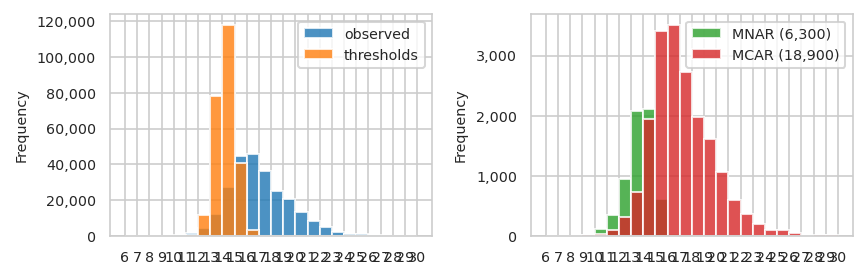

In [51]:
N = len(df_long)
N_MCAR = len(fake_na_mcar)
N_MNAR = len(fake_na_mnar)

fig, axes = plt.subplots(1, 2, figsize=(6, 2))
ax = axes[0]
plot_histogram_intensities = partial(pimmslearn.plotting.data.plot_histogram_intensities,
                                     min_max=min_max,
                                     alpha=0.8)
plot_histogram_intensities(
    df_long.squeeze(),
    ax=ax,
    label='observed')
plot_histogram_intensities(
    thresholds,
    ax=ax,
    label='thresholds')
if args.use_every_nth_xtick > 1:
    ax.set_xticks(ax.get_xticks()[::2])
ax.legend()
ax = axes[1]
plot_histogram_intensities(
    fake_na_mnar.squeeze(),
    ax=ax,
    label=f'MNAR ({N_MNAR:,d})',
    color='C2')
plot_histogram_intensities(
    fake_na_mcar.squeeze(),
    ax=ax,
    color='C3',
    label=f'MCAR ({N_MCAR:,d})')
if args.use_every_nth_xtick > 1:
    ax.set_xticks(ax.get_xticks()[::2])
ax.legend()
fname = args.out_figures / f'0_{group}_mnar_mcar_histograms.pdf'
figures[fname.stem] = fname
pimmslearn.savefig(fig, fname)

In [52]:
counts_per_bin = pimmslearn.pandas.get_counts_per_bin(
    df=pd.concat(
        [df_long.squeeze().to_frame('observed'),
         thresholds.to_frame('threshold'),
         fake_na_mnar.squeeze().to_frame(f'MNAR ({N_MNAR:,d})'),
         fake_na_mcar.squeeze().to_frame(f'MCAR ({N_MCAR:,d})')],
        axis=1),
    bins=range(min_max[0], min_max[1] + 1, 1))
counts_per_bin.to_excel(fname.with_suffix('.xlsx'))
counts_per_bin

/home/runner/work/pimms/pimms/project/.snakemake/conda/924ec7e362d761ecf0807b9074d79999_/lib/python3.12/site-packages/pimmslearn/pandas/__init__.py:320: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/runner/work/pimms/pimms/project/.snakemake/conda/924ec7e362d761ecf0807b9074d79999_/lib/python3.12/site-packages/pimmslearn/pandas/__init__.py:320: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/runner/work/pimms/pimms/project/.snakemake/conda/924ec7e362d761ecf0807b9074d79999_/lib/python3.12/site-packages/pimmslearn/pandas/__init__.py:320: FutureWarning:

The default of observed=False is deprecated and w

observed  threshold  MNAR (6,300)  MCAR (18,900)
bin                                                       
(6, 7]           1          0             0              1
(7, 8]           4          0             2              0
(8, 9]          39          0             8              2
(9, 10]        136          0            20             13
(10, 11]       529          3           114             29
(11, 12]     1,731        387           353            103
(12, 13]     4,644     11,870           953            310
(13, 14]    12,161     77,911         2,085            729
(14, 15]    27,515    117,843         2,120          1,951
(15, 16]    44,723     40,668           611          3,406
(16, 17]    45,981      3,261            33          3,511
(17, 18]    36,274         63             1          2,733
(18, 19]    25,049          3             0          1,975
(19, 20]    20,386          0             0          1,619
(20, 21]    13,495          0             0          1,061
(21, 22]     8,234          0             0            602
(22, 23]     4,885          0             0            367
(23, 24]     2,459          0             0            197
(24, 25]     1,237          0             0             98
(25, 26]     1,392          0             0            108
(26, 27]       643          0             0             46
(27, 28]        88          0             0              4
(28, 29]       216          0             0             15
(29, 30]       163          0             0             18
(30, 31]        24          0             0              2

### Keep simulated samples only in a subset of the samples
In case only a subset of the samples should be used for validation and testing,
although these samples can be used for fitting the models,
the following cell will select samples stratified by the eventually set `meta_cat_col` column.

The procedure is experimental and turned off by default.

In [53]:
if 0.0 < args.prop_sample_w_sim < 1.0:
    to_stratify = None
    if args.meta_cat_col and df_meta is not None:
        to_stratify = df_meta[args.meta_cat_col].fillna(-1)  # ! fillna with -1 as separate category (sofisticate check)
    train_idx, val_test_idx = train_test_split(splits.train_X.index.levels[0],
                                               test_size=args.prop_sample_w_sim,
                                               stratify=to_stratify,
                                               random_state=42)
    val_idx, test_idx = train_test_split(val_test_idx,
                                         test_size=.5,
                                         stratify=to_stratify.loc[val_test_idx] if to_stratify is not None else None,
                                         random_state=42)
    logger.info(f"Sample in Train: {len(train_idx):,d} - Validation: {len(val_idx):,d} - Test: {len(test_idx):,d}")
    # reassign some simulated missing values to training data:
    splits.train_X = pd.concat(
        [splits.train_X,
         splits.val_y.loc[train_idx],
         splits.test_y.loc[train_idx]
         ])
    splits.val_y = splits.val_y.loc[val_idx]
    splits.test_y = splits.test_y.loc[test_idx]
    logger.info(f"New shapes: {splits.train_X.shape = } - {splits.val_y.shape = } - {splits.test_y.shape = }")

In [54]:
splits.test_y.groupby(level=-1).count().describe()

count   1,418.000
mean        8.886
std         3.986
min         1.000
25%         6.000
50%         8.000
75%        11.000
max        32.000
Name: intensity, dtype: float64

In [55]:
splits.val_y

Sample ID   protein groups                   
Sample_158  Q9UN70;Q9UN70-2                     14.630
Sample_050  Q9Y287                              15.755
Sample_107  Q8N475;Q8N475-2                     15.029
Sample_199  P06307                              19.376
Sample_067  Q5VUB5                              15.309
                                                 ...  
Sample_111  F6SYF8;Q9UBP4                       22.822
Sample_002  A0A0A0MT36                          18.165
Sample_049  Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4   15.525
Sample_182  Q8NFT8                              14.379
Sample_123  Q16853;Q16853-2                     14.504
Name: intensity, Length: 12600, dtype: float64

In [56]:
splits.train_X.groupby(level=-1).count().describe()

count   1,421.000
mean      159.612
std        42.227
min        36.000
25%       134.000
50%       179.000
75%       192.000
max       203.000
Name: intensity, dtype: float64

In [57]:
# Check that feature indices and sample indicies overlap between splits
# -> a single feature cannot be only in the validation or test split
# -> single features should be put into the training data
# -> or raise error as feature completness treshold is so low that less than 3 samples
# per feature are allowd.

splits = pimmslearn.sampling.check_split_integrity(splits)

Some tools require at least 4 observation in the training data,
which is a good requirment. Due to "MNAR" sampling, most measurments
of a features can end up in the validation or test data.

In that case: Move the validation measurments back to the training data.
If after this procedure the condition is still not met, a value error is raised.

In [58]:
mask_min_4_measurments = splits.train_X.groupby(level=1).count() < 4
if mask_min_4_measurments.any():
    idx = mask_min_4_measurments.loc[mask_min_4_measurments].index
    logger.warning(f"Features with less than 4 measurments in training data: {idx.to_list()}")
    to_remove = splits.val_y.loc[pd.IndexSlice[:, idx]]
    logger.info("To remove from validation data: ")
    display(to_remove)
    splits.train_X = pd.concat([splits.train_X, to_remove])
    splits.val_y = splits.val_y.drop(to_remove.index)
    # check condition again
    mask_min_4_measurments = splits.train_X.groupby(level=1).count() < 4
    if mask_min_4_measurments.any():
        idx = mask_min_4_measurments.loc[mask_min_4_measurments].index
        raise ValueError("Some features still have less than 4 measurments in training data"
                         f" after removing the features from the validation data: {idx.to_list()}")

### Save in long format

- Data in long format: (peptide, sample_id, intensity)
- no missing values kept

In [59]:
# dumps data in long-format
splits_dumped = splits.dump(folder=args.data, file_format=args.file_format)
dumps.update(splits_dumped)
splits_dumped

pimmslearn.io.datasplits - INFO     'test_y' has shape: (12600,)


pimmslearn.io.datasplits - INFO     save 'test_y' to file: runs/alzheimer_study/data/test_y.csv


pimmslearn.io.datasplits - INFO     'train_X' has shape: (226809,)


pimmslearn.io.datasplits - INFO     save 'train_X' to file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     'val_y' has shape: (12600,)


pimmslearn.io.datasplits - INFO     save 'val_y' to file: runs/alzheimer_study/data/val_y.csv


{'test_y.csv': 'runs/alzheimer_study/data/test_y.csv',
 'train_X.csv': 'runs/alzheimer_study/data/train_X.csv',
 'val_y.csv': 'runs/alzheimer_study/data/val_y.csv'}

### Reload from disk

In [60]:
splits = DataSplits.from_folder(args.data, file_format=args.file_format)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


## plot distribution of splits

In [61]:
splits_df = pd.DataFrame(index=df_long.index)
splits_df['train'] = splits.train_X
splits_df['val'] = splits.val_y
splits_df['test'] = splits.test_y
stats_splits = splits_df.describe()
stats_splits.to_excel(writer, 'stats_splits', float_format='%.3f')
stats_splits

/tmp/ipykernel_3011/3486782611.py:6: FutureWarning:

Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.



train        val       test
count 226,809.000 12,600.000 12,600.000
mean       17.206     16.340     16.339
std         2.533      2.717      2.741
min         7.068      6.695      7.209
25%        15.506     14.395     14.412
50%        16.805     15.958     15.935
75%        18.626     17.931     17.910
max        30.735     29.841     30.140

In [62]:
# whitespaces in legends are not displayed correctly...
# max_int_len   = len(str(int(stats_splits.loc['count'].max()))) +1
# _legend = [
#     f'{s:<5} (N={int(stats_splits.loc["count", s]):>{max_int_len},d})'.replace(
#         ' ', '\u00A0')
#     for s in ('train', 'val', 'test')]
_legend = [
    f'{s:<5} (N={int(stats_splits.loc["count", s]):,d})'
    for s in ('train', 'val', 'test')]
print(_legend)

['train (N=226,809)', 'val   (N=12,600)', 'test  (N=12,600)']


pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/0_3_val_over_train_split.pdf


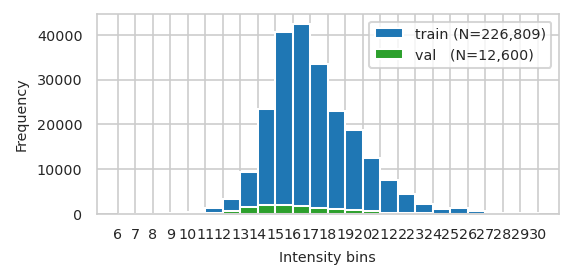

In [63]:
group = 3
ax = (splits
      .train_X
      .plot
      .hist(
          bins=bins,
          ax=None,
          color='C0',
      ))
_ = (splits
     .val_y
     .plot
     .hist(bins=bins,
           xticks=list(bins),
           ax=ax,
           color='C2',
           legend=True)
     )
ax.legend(_legend[:-1])
if args.use_every_nth_xtick > 1:
    ax.set_xticks(ax.get_xticks()[::2])
ax.set_xlabel('Intensity bins')
fname = args.out_figures / f'0_{group}_val_over_train_split.pdf'
figures[fname.name] = fname
pimmslearn.savefig(ax.get_figure(), fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/0_3_splits_freq_stacked.pdf


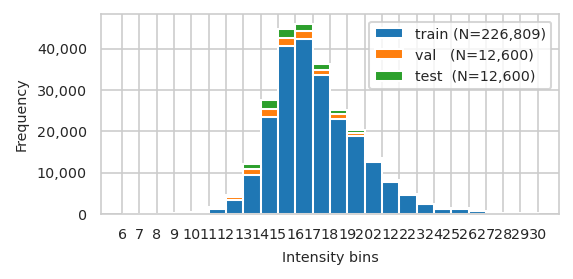

In [64]:
min_bin, max_bin = pimmslearn.plotting.data.min_max(splits.val_y)
bins = range(int(min_bin), int(max_bin) + 1, 1)
ax = splits_df.plot.hist(bins=bins,
                         xticks=list(bins),
                         legend=False,
                         stacked=True,
                         color=['C0', 'C1', 'C2'],
                         )
if args.use_every_nth_xtick > 1:
    ax.set_xticks(ax.get_xticks()[::2])
ax.legend(_legend)
ax.set_xlabel('Intensity bins')
ax.yaxis.set_major_formatter("{x:,.0f}")
fname = args.out_figures / f'0_{group}_splits_freq_stacked.pdf'
figures[fname.name] = fname
pimmslearn.savefig(ax.get_figure(), fname)

In [65]:
counts_per_bin = pimmslearn.pandas.get_counts_per_bin(df=splits_df, bins=bins)
counts_per_bin.to_excel(fname.with_suffix('.xlsx'))
counts_per_bin

/home/runner/work/pimms/pimms/project/.snakemake/conda/924ec7e362d761ecf0807b9074d79999_/lib/python3.12/site-packages/pimmslearn/pandas/__init__.py:320: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/runner/work/pimms/pimms/project/.snakemake/conda/924ec7e362d761ecf0807b9074d79999_/lib/python3.12/site-packages/pimmslearn/pandas/__init__.py:320: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/runner/work/pimms/pimms/project/.snakemake/conda/924ec7e362d761ecf0807b9074d79999_/lib/python3.12/site-packages/pimmslearn/pandas/__init__.py:320: FutureWarning:

The default of observed=False is deprecated and w

train   val  test
bin                        
(6, 7]        0     1     0
(7, 8]        2     0     2
(8, 9]       29     3     7
(9, 10]     103    15    18
(10, 11]    386    74    69
(11, 12]  1,275   239   217
(12, 13]  3,381   629   634
(13, 14]  9,347 1,420 1,394
(14, 15] 23,444 2,029 2,042
(15, 16] 40,706 1,963 2,054
(16, 17] 42,437 1,757 1,787
(17, 18] 33,540 1,401 1,333
(18, 19] 23,074 1,010   965
(19, 20] 18,767   827   792
(20, 21] 12,434   525   536
(21, 22]  7,632   282   320
(22, 23]  4,518   185   182
(23, 24]  2,262    95   102
(24, 25]  1,139    53    45
(25, 26]  1,284    58    50
(26, 27]    597    21    25
(27, 28]     84     1     3
(28, 29]    201     7     8
(29, 30]    145     5    13

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/0_3_val_test_split_freq_stacked_.pdf


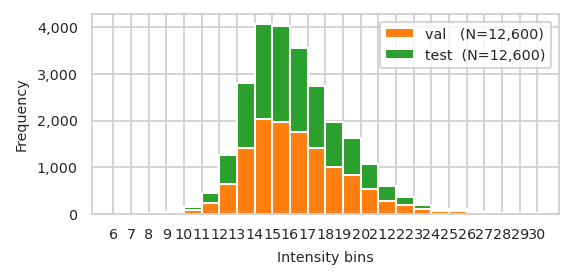

In [66]:
ax = splits_df.drop('train', axis=1).plot.hist(bins=bins,
                                               xticks=list(bins),
                                               color=['C1', 'C2'],
                                               legend=False,
                                               stacked=True,
                                               )
if args.use_every_nth_xtick > 1:
    ax.set_xticks(ax.get_xticks()[::2])
ax.legend(_legend[1:])
ax.set_xlabel('Intensity bins')
ax.yaxis.set_major_formatter("{x:,.0f}")
fname = args.out_figures / f'0_{group}_val_test_split_freq_stacked_.pdf'
figures[fname.name] = fname
pimmslearn.savefig(ax.get_figure(), fname)

plot training data missing plots

In [67]:
splits.to_wide_format()

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/0_3_intensity_median_vs_prop_missing_scatter_train


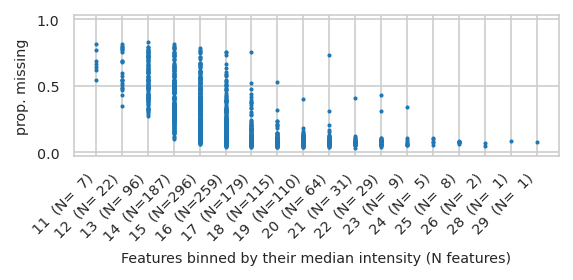

In [68]:
ax = pimmslearn.plotting.data.plot_feat_median_over_prop_missing(
    data=splits.train_X, type='scatter')
fname = args.out_figures / f'0_{group}_intensity_median_vs_prop_missing_scatter_train'
figures[fname.stem] = fname
pimmslearn.savefig(ax.get_figure(), fname)

/home/runner/work/pimms/pimms/project/.snakemake/conda/924ec7e362d761ecf0807b9074d79999_/lib/python3.12/site-packages/pimmslearn/plotting/data.py:327: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/0_3_intensity_median_vs_prop_missing_boxplot_train


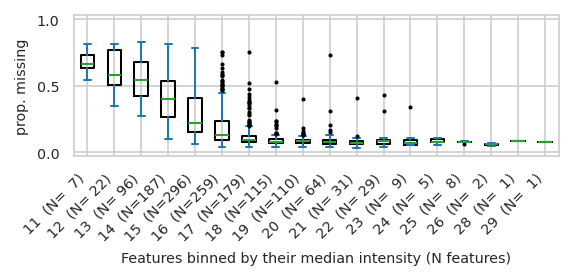

In [69]:
ax = pimmslearn.plotting.data.plot_feat_median_over_prop_missing(
    data=splits.train_X, type='boxplot')
fname = args.out_figures / f'0_{group}_intensity_median_vs_prop_missing_boxplot_train'
figures[fname.stem] = fname
pimmslearn.savefig(ax.get_figure(), fname)

/tmp/ipykernel_3011/657883200.py:16: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared.



pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/0_3_intensity_median_vs_prop_missing_boxplot_val_train


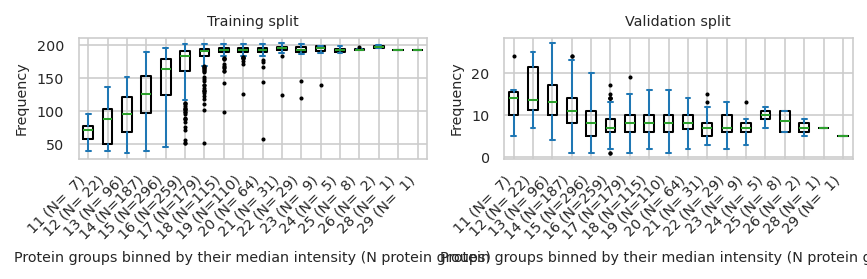

In [70]:
medians = (splits
           .train_X
           .median()
           .astype(int)
           ).to_frame('median_floor')

feat_with_median = medians.groupby('median_floor').size().rename('M feat')
medians = medians.join(feat_with_median, on='median_floor')
medians = medians.apply(lambda s: "{:02,d} (N={:3,d})".format(*s), axis=1)

fig, ax = plt.subplots(figsize=(6, 2))
s = 1
s_axes = pd.DataFrame({'medians': medians,
                       'Validation split': splits.val_y.notna().sum(),
                       'Training split': splits.train_X.notna().sum()}
                      ).plot.box(by='medians',
                                 boxprops=dict(linewidth=s),
                                 flierprops=dict(markersize=s),
                                 ax=ax)
for ax in s_axes:
    _ = ax.set_xticklabels(ax.get_xticklabels(),
                           rotation=45,
                           horizontalalignment='right')
    ax.set_xlabel(f'{args.feat_name_display.capitalize()} binned by their median intensity '
                  f'(N {args.feat_name_display})')
    _ = ax.set_ylabel('Frequency')
fname = args.out_figures / f'0_{group}_intensity_median_vs_prop_missing_boxplot_val_train'
figures[fname.stem] = fname
pimmslearn.savefig(ax.get_figure(), fname)

## Save parameters

In [71]:
fname = args.folder_experiment / 'data_config.yaml'
args.dump(fname)
args

root - INFO     Dumped config to: runs/alzheimer_study/data_config.yaml


{'FN_INTENSITIES': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/proteome.csv',
 'M': 1421,
 'N': 210,
 'column_names': ['protein groups'],
 'data': PosixPath('runs/alzheimer_study/data'),
 'feat_name_display': 'protein groups',
 'feat_prevalence': 52,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'frac_mnar': 0.25,
 'frac_non_train': 0.1,
 'index_col': [0],
 'logarithm': 'log2',
 'meta_cat_col': '_collection site',
 'meta_date_col': 'PlaceholderTime',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'prop_sample_w_sim': 1.0,
 'random_state': 42,
 'sample_N':

## Saved Figures

In [72]:
# saved figures
figures

{'0_1_hist_features_per_sample': PosixPath('runs/alzheimer_study/figures/0_1_hist_features_per_sample'),
 '0_1_feature_prevalence': PosixPath('runs/alzheimer_study/figures/0_1_feature_prevalence'),
 '0_1_intensity_distribution_overall': PosixPath('runs/alzheimer_study/figures/0_1_intensity_distribution_overall'),
 '0_1_intensity_median_vs_prop_missing_scatter': PosixPath('runs/alzheimer_study/figures/0_1_intensity_median_vs_prop_missing_scatter'),
 '0_1_intensity_median_vs_prop_missing_boxplot': PosixPath('runs/alzheimer_study/figures/0_1_intensity_median_vs_prop_missing_boxplot'),
 '0_1_pca_sample_by__collection_site': PosixPath('runs/alzheimer_study/figures/0_1_pca_sample_by__collection_site'),
 '0_1_pca_sample_by_identified_protein_groups': PosixPath('runs/alzheimer_study/figures/0_1_pca_sample_by_identified_protein_groups.pdf'),
 '0_1_pca_sample_by_identified_protein_groups_plotly': PosixPath('runs/alzheimer_study/figures/0_1_pca_sample_by_identified_protein_groups_plotly.pdf'),
 '

Saved dumps

In [73]:
writer.close()
dumps

{'01_0_data_stats.xlsx': 'runs/alzheimer_study/01_0_data_stats.xlsx',
 'freq_features.json': PosixPath('runs/alzheimer_study/data/freq_features.json'),
 'freq_features.pkl': PosixPath('runs/alzheimer_study/data/freq_features.pkl'),
 'test_y.csv': 'runs/alzheimer_study/data/test_y.csv',
 'train_X.csv': 'runs/alzheimer_study/data/train_X.csv',
 'val_y.csv': 'runs/alzheimer_study/data/val_y.csv'}